# Pymaceuticals Inc.
---

### Analysis

#### Assumptions: 
 - we are providing the analysis in order to compare the performance of Capomulin, against the other treatment regimens and identify the most effective treatment and factors that affect the treatment <br>
 - everyone understands that the size of data is pretty low to be reliable <br>
 - timepoints are specific points of time when samples are taken and the timepoints are defined based on the same intervals for all the mice. The higher is value of a timepoint the longer the mouse is under the treatment. One of the main reasons specific mouse has low last timepoint is that it is not alive anymore. <br>
 - the lower is tumor volume the better is result (positive effect of treatment) <br>
#### Summary:
Within the set of 248 mice and 10 drugs, Capomulin and Ramicane are the only treatments, which showed positive effect, with Capomulin that has most constant results and highest number of mice at the final timepoint. With Capomulin the volume tumor decreased in average from 45 to 36.2 having 84% mice present at the final timepoint.<br>
#### Dependencies:
 - While treated with Capomulin, there was a dependency of tumor volume from an initial weight with a correlation 0.84 (the higher the weight the higher is average tumor volume). <br>
 - At the initial timepoint proportion of Female:Male was 48:52 for Capomulin, while at the final timepoint  it was 43:57. <br>
 
#### Few details, that do not seem so important:
 - Interesting case with Infubinol, for which there is an outlier with pretty low  tumour volume, but when we look at it (c326) then we can see that it has only 2 timepoints and after the high decrease in tumour the mouse disappeared from our lists, which does not seem to be a good sign. Similar case (f966) there is for Capomulin, when a mouse had rapid decrease in volume and after that disappeared from our list. Maybe its worth to investigate those cases.


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from pathlib import Path
import numpy as np

# Study data files
mouse_metadata_path = Path("data/Mouse_metadata.csv")
study_results_path = Path("data/Study_results.csv")

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame
combined_mouse_results=pd.merge(study_results,mouse_metadata,on="Mouse ID", how="outer").sort_values(by=["Timepoint","Tumor Volume (mm3)"])

# Display the data table for preview
combined_mouse_results.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
10,f932,0,45.0,0,Ketapril,Male,15,29
11,g107,0,45.0,0,Ketapril,Female,2,29
19,a457,0,45.0,0,Ketapril,Female,11,30
22,c819,0,45.0,0,Ketapril,Male,21,25


In [2]:
# Checking the number of mice.
mice_count_original=combined_mouse_results["Mouse ID"].nunique()
mice_count_original

249

In [3]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mouse_ids_with_duplicates=combined_mouse_results[combined_mouse_results.duplicated(subset=["Mouse ID","Timepoint"])]["Mouse ID"].unique()
mouse_ids_with_duplicates

array(['g989'], dtype=object)

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
mice_duplicated=combined_mouse_results[combined_mouse_results["Mouse ID"].isin(mouse_ids_with_duplicates)]
mice_duplicated

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
combined_mouse_results_cleaned=combined_mouse_results[~combined_mouse_results["Mouse ID"].isin(mouse_ids_with_duplicates)].reset_index(drop=True)
combined_mouse_results_cleaned.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [6]:
# Checking the number of mice in the clean DataFrame.
mice_count_cleaned=combined_mouse_results_cleaned["Mouse ID"].nunique()
mice_count_cleaned

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 

groupped_mouse_results=combined_mouse_results_cleaned.groupby("Drug Regimen")

tumor_avg=groupped_mouse_results["Tumor Volume (mm3)"].mean()
tumor_median=groupped_mouse_results["Tumor Volume (mm3)"].median()
tumor_var=groupped_mouse_results["Tumor Volume (mm3)"].var()
tumor_std=groupped_mouse_results["Tumor Volume (mm3)"].std()
tumor_sem=groupped_mouse_results["Tumor Volume (mm3)"].sem()

# Assemble the resulting series into a single summary DataFrame.
summary_statistics=pd.DataFrame({"Mean Tumor Volume":tumor_avg, 
                                 "Median Tumor Volume":tumor_median,
                                 "Tumor Volume Variance":tumor_var,
                                 "Tumor Volume Std. Dev.":tumor_std,
                                 "Tumor Volume Std. Err.":tumor_sem})
summary_statistics

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line
summary_statistics_agg=combined_mouse_results_cleaned.groupby("Drug Regimen").agg({'Tumor Volume (mm3)':["mean","median","var","std","sem"]})
summary_statistics_agg

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

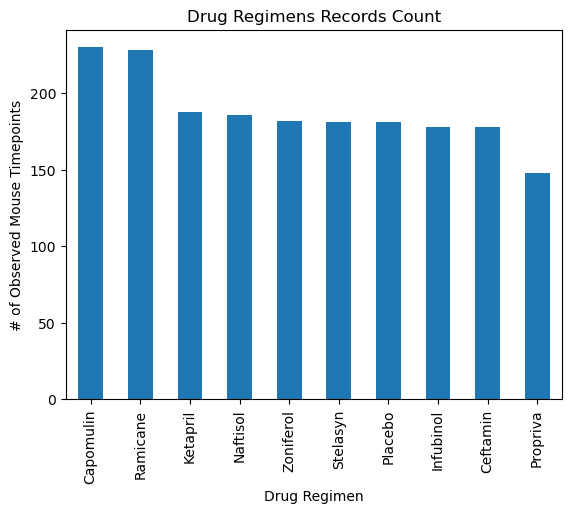

In [9]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
total_rows_per_drug_option1=combined_mouse_results_cleaned["Drug Regimen"].value_counts()
pl1=total_rows_per_drug_option1.plot(kind="bar", xlabel=combined_mouse_results_cleaned.columns[4], ylabel="# of Observed Mouse Timepoints", title="Drug Regimens Records Count")
plt.xticks(np.arange(len(total_rows_per_drug_option1)))
pl1.set_xticklabels(total_rows_per_drug_option1.index, rotation=90)
plt.show()


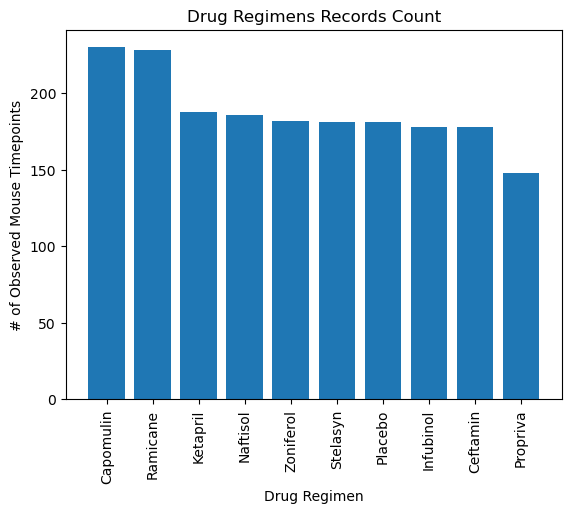

In [10]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
total_rows_per_drug=pd.DataFrame(combined_mouse_results_cleaned.groupby("Drug Regimen").size()).sort_values(by=[0,"Drug Regimen"], ascending=False)
plt.bar(total_rows_per_drug.index, total_rows_per_drug[0], width=0.8, align='center')
plt.xticks(ticks=[i for i in range(len(total_rows_per_drug[0]))],labels=total_rows_per_drug.index, rotation=90)
plt.xlabel("Drug Regimen")
plt.ylabel("# of Observed Mouse Timepoints")
plt.title("Drug Regimens Records Count")
plt.show()

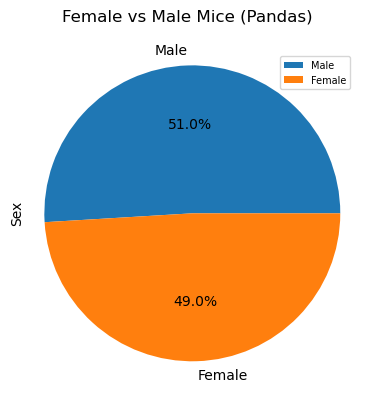

<Figure size 640x480 with 0 Axes>

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
gender_distribution=combined_mouse_results_cleaned.groupby("Sex")["Mouse ID"].count().sort_values(ascending=False)
gender_distribution.plot(kind="pie",figsize=(4.2,4.2),autopct="%1.1f%%",labels=gender_distribution.index, ylabel="Sex")
plt.suptitle("Female vs Male Mice (Pandas)")
plt.legend(loc="best", fontsize=7)
plt.axis("equal")
plt.show()
plt.tight_layout()


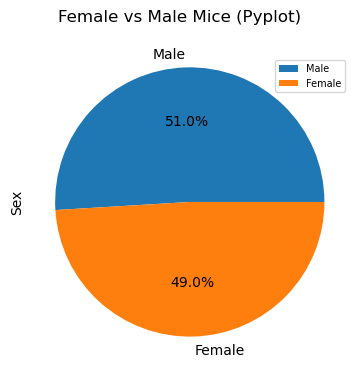

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.figure(figsize=(3.7,3.7))
plt.pie(gender_distribution,labels=gender_distribution.index, autopct='%1.1f%%')
plt.ylabel("Sex")
plt.axis("equal")
plt.suptitle("Female vs Male Mice (Pyplot)")
plt.legend(loc="best", fontsize=7)
plt.tight_layout()
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
filtered_treatment=combined_mouse_results_cleaned[combined_mouse_results_cleaned["Drug Regimen"].isin(["Capomulin","Ramicane","Infubinol","Ceftamin"])].reset_index(drop=True)

# Start by getting the last (greatest) timepoint for each mouse
last_timepoint=filtered_treatment.groupby("Mouse ID")["Timepoint"].max()
last_timepoint=pd.DataFrame(last_timepoint).rename(columns={0:"Timepoint"})

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
last_timepoint=pd.merge(last_timepoint,filtered_treatment, on=["Mouse ID","Timepoint"], how="left")
last_timepoint=last_timepoint.set_index("Mouse ID")
last_timepoint

,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,,,,
a203,45,67.973419,2,Infubinol,Female,20,23
a251,45,65.525743,1,Infubinol,Female,21,25
a275,45,62.999356,3,Ceftamin,Female,20,28
a411,45,38.407618,1,Ramicane,Male,3,22
a444,45,43.047543,0,Ramicane,Female,10,25
...,...,...,...,...,...,...,...
y769,45,68.594745,4,Ceftamin,Female,6,27
y793,45,31.896238,2,Capomulin,Male,17,17
y865,45,64.729837,3,Ceftamin,Male,23,26


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
treatments=["Capomulin","Ramicane","Infubinol","Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol_list=[]

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
for treatment in treatments:
    tumor_vol_series=(last_timepoint[last_timepoint["Drug Regimen"]==treatment]["Tumor Volume (mm3)"])
    # add subset 
    tumor_vol_list.append(tumor_vol_series)
    # Determine outliers using upper and lower bounds
    quartiles=tumor_vol_series.quantile([.25,.5,.75])
    q1 = quartiles[0.25]
    q3 = quartiles[0.75]
    iqr = q3-q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outlier_treatment=tumor_vol_series[(tumor_vol_series<lower_bound)|(tumor_vol_series>upper_bound)]
    # Print the results
    if len(outlier_treatment) > 0: 
        if len(outlier_treatment)>1: print(f"{treatment}'s potential outliers \n {outlier_treatment}")
        else: print(f"{treatment}'s potential outlier \n {outlier_treatment}")
    else: print(f"There are no potential outliers for {treatment}")
                

There are no potential outliers for Capomulin
There are no potential outliers for Ramicane
Infubinol's potential outlier 
 Mouse ID
c326    36.321346
Name: Tumor Volume (mm3), dtype: float64
There are no potential outliers for Ceftamin


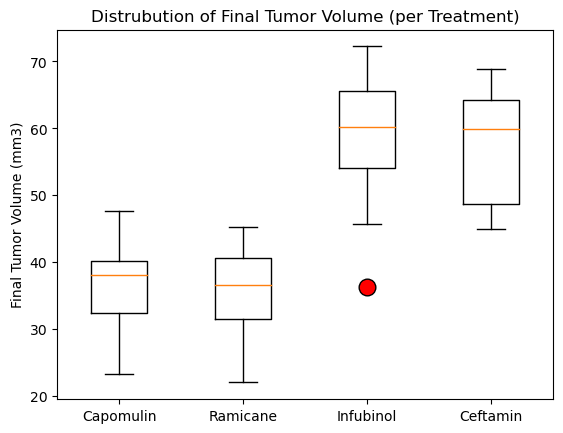

In [15]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
bp=plt.boxplot(tumor_vol_list, labels=treatments)
plt.setp(bp['fliers'], marker="o", markersize=12, markerfacecolor = "red", markeredgecolor="black")
plt.ylabel("Final Tumor Volume (mm3)")
plt.title("Distrubution of Final Tumor Volume (per Treatment)")
plt.show()

## Line and Scatter Plots

Please make a selection from the following IDs for mouses treated with Capomulin: 
 Enter 0 for b128 mouseID with 10 records 
 Enter 1 for v923 mouseID with 10 records 
 Enter 2 for m957 mouseID with 10 records 
 Enter 3 for i557 mouseID with 10 records 
 Enter 4 for t565 mouseID with 10 records 
 Enter 5 for l897 mouseID with 10 records 
 Enter 6 for g288 mouseID with 10 records 
 Enter 7 for g316 mouseID with 10 records 
 Enter 8 for y793 mouseID with 10 records 
 Enter 9 for r944 mouseID with 10 records 
 Enter 10 for i738 mouseID with 10 records 
 Enter 11 for w914 mouseID with 10 records 
 Enter 12 for j119 mouseID with 10 records 
 Enter 13 for u364 mouseID with 10 records 
 Enter 14 for s710 mouseID with 10 records 
 Enter 15 for l509 mouseID with 10 records 
 Enter 16 for x401 mouseID with 10 records 
 Enter 17 for b742 mouseID with 10 records 
 Enter 18 for s185 mouseID with 10 records 
 Enter 19 for r554 mouseID with 10 records 
 Enter 20 for m601 mouseID with 10 records 
 En

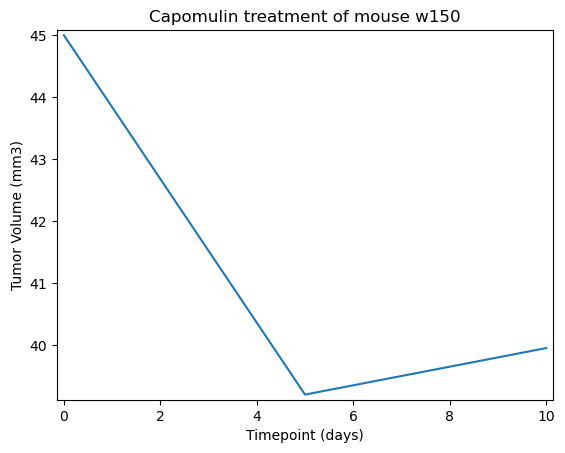

In [22]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
#receive all mice treated with Capomulin
mouse_ids_capomulin=combined_mouse_results_cleaned[combined_mouse_results_cleaned["Drug Regimen"]=="Capomulin"]["Mouse ID"].value_counts()

#suggest user to select for which mouse they want to preview changes in tumor over time 
# (if they made wrong selection 2 concequtive times default choice will be made with the id shown in answer for comparison)
options_message="Please make a selection from the following IDs for mouses treated with Capomulin: \n"
duration=np.arange(len(mouse_ids_capomulin))
for i in duration: 
    options_message += (f" Enter {i} for {mouse_ids_capomulin.index[i]} mouseID with {mouse_ids_capomulin[i]} records \n")

last=duration[len(mouse_ids_capomulin)-1]
first=duration[0]

for i in range(1,3,1):
    try:
        mouse_index_id=int(input(options_message))
        if mouse_index_id in duration: break
        elif i<2: 
            options_message+=(f"You have one last try. Please enter a number from {first} to {last}. \n")
        elif i==2:
            print(f"You entered not quit proper value twice, so we will make the choice for you. Let us select {mouse_ids_capomulin.index[15]} mouseID with {mouse_ids_capomulin[15]} records")
            mouse_index_id=15
    except ValueError:
        if i<2: 
            options_message+=(f"You have one last try. Please enter a number from {first} to {last}. \n")
        elif i==2:
            print(f"You entered not quit proper value twice, so we will make the choice for you. Let select {mouse_ids_capomulin.index[15]} mouseID with {mouse_ids_capomulin[15]} records")
            mouse_index_id=15

print(f"So, the chart will be shown for {mouse_ids_capomulin.index[mouse_index_id]} mouseID with {mouse_ids_capomulin[mouse_index_id]} records")

#select necessary data for plotting and actually draw the line
tumor_time=combined_mouse_results_cleaned.loc[combined_mouse_results_cleaned["Mouse ID"] == mouse_ids_capomulin.index[mouse_index_id],["Timepoint","Tumor Volume (mm3)"]].set_index("Timepoint")

tumor_time["Tumor Volume (mm3)"].plot(xlabel="Timepoint (days)", ylabel="Tumor Volume (mm3)", title=f"Capomulin treatment of mouse {mouse_ids_capomulin.index[mouse_index_id]}")
delta_x=(tumor_time.index.max()-tumor_time.index.min())/70
plt.xlim(tumor_time.index.min()-delta_x, tumor_time.index.max()+delta_x)
delta_y=(tumor_time["Tumor Volume (mm3)"].max()-tumor_time["Tumor Volume (mm3)"].min())/70
plt.ylim(tumor_time["Tumor Volume (mm3)"].min()-delta_y,tumor_time["Tumor Volume (mm3)"].max()+delta_y)
plt.show()


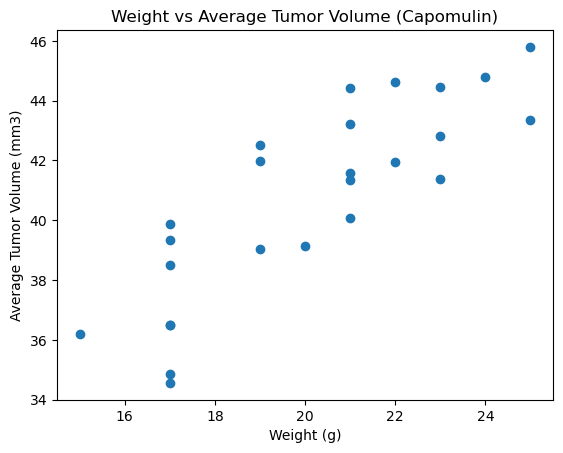

In [23]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
capomulin_weight_tumor=combined_mouse_results_cleaned.loc[combined_mouse_results_cleaned["Drug Regimen"]=="Capomulin",["Mouse ID","Tumor Volume (mm3)","Weight (g)"]].set_index("Mouse ID")
capomulin_weight_tumor_avg=capomulin_weight_tumor.groupby("Mouse ID")[["Tumor Volume (mm3)","Weight (g)"]].mean()
x = capomulin_weight_tumor_avg["Weight (g)"]
y = capomulin_weight_tumor_avg["Tumor Volume (mm3)"]
plt.title("Weight vs Average Tumor Volume (Capomulin)")
plt.scatter(x,y)
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.84


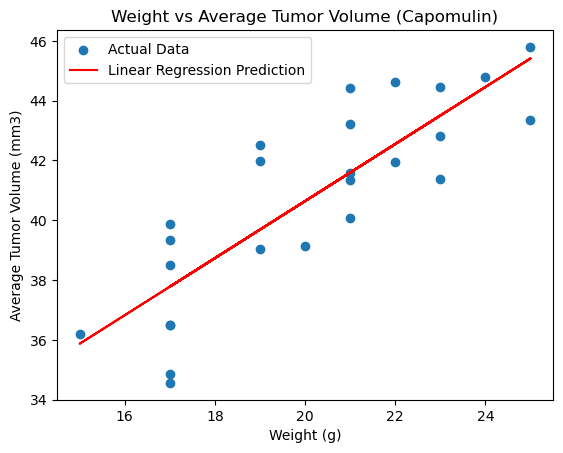

In [24]:
# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen

  #correlation:
correlation_weight_tumor=round(st.pearsonr(x,y)[0],2)
print(f"The correlation between mouse weight and the average tumor volume is {correlation_weight_tumor}")

  #linear regression:
slope = st.linregress(x,y)[0]
intercept = st.linregress(x,y)[1]

prediction = slope * x + intercept

fig, ax = plt.subplots()
ax.scatter(x,y,color="tab:blue",label="Actual Data")
ax.plot(x,prediction, color="r",label="Linear Regression Prediction")
ax.set_ylabel("Average Tumor Volume (mm3)")
ax.set_xlabel("Weight (g)")
ax.set_title("Weight vs Average Tumor Volume (Capomulin)")
ax.legend(loc="best")
plt.show()
